In [132]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import sklearn
import sklearn.neighbors
from pathlib import Path
from pandas.api.types import CategoricalDtype
from operator import itemgetter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import torch

import warnings
warnings.filterwarnings('ignore')

# constants
RAW_DATA_PATH = Path('raw_data/')
DATAFRAME_PATH = Path('dataframes/')
MODEL_PATH = Path('model/ncf_model.pt')
TOTAL_TRACKS = 50
NUM_WITHHELD = 25
N_NEIGHBORS = 500
SELECTED_TRACK_FEATURES = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness',  'liveness', 'valence',
                           'tempo','key', 'loudness',
                          ]

In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [134]:
tracks_features_df = pd.read_hdf(DATAFRAME_PATH / 'tracks_features_df.h5', 'tracks_features_df')
cat_type = CategoricalDtype(categories=tracks_features_df.tid, ordered=True)
tracks_features_df.tid = tracks_features_df.tid.astype(cat_type)

playlist_tracks_df = pd.read_hdf(DATAFRAME_PATH/'playlist_tracks_df.h5', 'playlist_tracks_df')
playlist_tracks_df.tid = playlist_tracks_df.tid.astype(cat_type)

playlists_info_df = pd.read_hdf(DATAFRAME_PATH/'playlists_info_df.h5', 'playlists_info_df')

display(tracks_features_df.sample(2))
display(playlist_tracks_df.sample(2))
display(playlists_info_df.sample(2))

,tid,uri,artist_name,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
89953,89953,spotify:track:477Lck4fZcshudQnEcoxMB,Oscar D'León,Que Bueno Baila Usted,0.818,0.769,5,-6.100,1,0.0479,0.467,0.000005,0.217,0.967,92.961,215655,4
26128,26128,spotify:track:1BRncMyUJpjOeBortJt5pD,Jerry Garcia,Sitting Here In Limbo,0.692,0.296,0,-12.331,1,0.0333,0.892,0.014200,0.672,0.666,126.715,424200,4


,tid,uri,pid,pos
81626,148799,spotify:track:6oXUzxFOfdXbD8ivAfAraN,1214,96
538224,121141,spotify:track:5XlRgoTOGC8R8Aw0t7q6HS,8048,62


,pid,playlist_name
877,877,ELECTRONICAS
8187,8187,november 2014


In [135]:
# scale features before feeding to the knn model
scaler = MinMaxScaler()
tracks_features_df[SELECTED_TRACK_FEATURES] = pd.DataFrame(scaler.fit_transform(tracks_features_df[SELECTED_TRACK_FEATURES]), columns=SELECTED_TRACK_FEATURES)
tracks_features_df[SELECTED_TRACK_FEATURES]

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,loudness
0,0.921292,0.748,0.044444,0.074799,0.000957,0.0403,0.864,0.484106,0.818182,0.903770
1,0.448032,0.991,0.138110,0.000085,0.000084,0.1200,0.106,0.525980,0.636364,0.889542
2,0.305752,0.616,0.038733,0.243976,0.000003,0.1340,0.219,0.333670,0.909091,0.821018
3,0.754793,0.627,0.066355,0.131526,0.000000,0.0852,0.524,0.513031,0.636364,0.859876
4,0.531786,0.793,0.036552,0.108434,0.000003,0.1440,0.597,0.530123,0.272727,0.879091
...,...,...,...,...,...,...,...,...,...,...
170084,0.710394,0.899,0.063344,0.037851,0.001011,0.3340,0.407,0.462310,0.545455,0.861055
170085,0.648840,0.922,0.045379,0.194779,0.778779,0.1470,0.605,0.508883,0.636364,0.861342
170086,0.604440,0.525,0.041225,0.731928,0.000046,0.0909,0.186,0.490561,0.818182,0.848469
170087,0.750757,0.581,0.151610,0.595382,0.958959,0.2040,0.679,0.538254,0.727273,0.793025


In [137]:
all_playlist_ids = playlist_tracks_df.pid.unique()
train_pids, test_pids = train_test_split(all_playlist_ids,random_state=0, test_size=0.20)
print(f'total playlists: {len(all_playlist_ids)}')
print(f'train playlists: {len(train_pids)}')
print(f'test playlists: {len(test_pids)}')
# 1. Get tracks that are only from the training playlists
# 2. Get the track features(danceability,loudness) for each of these training tracks
# 3. Make a test set that only includes tracks from the training set
train_playlist_tracks_df = playlist_tracks_df.query('pid in @train_pids')

train_tracks_features_df = tracks_features_df.query('tid in @train_playlist_tracks_df.tid')
test_playlist_tracks_df = playlist_tracks_df.query('pid in @test_pids and tid in @train_playlist_tracks_df.tid')
print()
print(f'total tracks in train playlists: {len(train_playlist_tracks_df)}')
print(f'unique tracks in train playlists: {len(train_tracks_features_df)}')


# 1. Get the first NUM_WITHHELD tracks for each playlist in test
# 2. Get the track features for these with held tracks
# 3. Compute mean features by grouping the tracks from incomplete playlists
test_playlist_tracks_incomplete_df = test_playlist_tracks_df.groupby('pid').head(NUM_WITHHELD)
test_tracks_incomplete_features_df = test_playlist_tracks_incomplete_df.merge(tracks_features_df,how='inner',on='tid')
test_playlist_incomplete_features = test_tracks_incomplete_features_df[['pid',*SELECTED_TRACK_FEATURES]].groupby('pid',as_index=False).mean()
print()
print(f'total tracks in test playlists: {len(test_playlist_tracks_df)}')
print(f'total tracks in incomplete test playlists: {len(test_playlist_tracks_incomplete_df)}')
print(f'total incomplete test playlists: {len(test_playlist_incomplete_features)}')

total playlists: 10000
train playlists: 8000
test playlists: 2000

total tracks in train playlists: 532827
unique tracks in train playlists: 147296

total tracks in test playlists: 107713
total tracks in incomplete test playlists: 42362
total incomplete test playlists: 1988


In [138]:
# KNN model that will find 25 nearest neighbors to the current playlist
knn_clf = sklearn.neighbors.NearestNeighbors(n_neighbors=N_NEIGHBORS)
knn_clf.fit(train_tracks_features_df[SELECTED_TRACK_FEATURES])
distances, indices = knn_clf.kneighbors(test_playlist_incomplete_features[SELECTED_TRACK_FEATURES])

In [139]:
# for each test playlist, get the 25 next nearest predicted tracks and add them to a table for evaluation
def get_predicted_playlist_tracks():
    for index, row in test_playlist_incomplete_features.iterrows():
            predicted_tracks = train_tracks_features_df['tid'].iloc[indices[index]]
            for pos, predicted_track in enumerate(predicted_tracks):
                yield predicted_track, int(row['pid']),pos

test_predicted_playlist_tracks_df = pd.DataFrame(get_predicted_playlist_tracks(), columns =['tid', 'pid', 'pos'])
test_predicted_playlist_tracks_df.tid = test_predicted_playlist_tracks_df.tid.astype(cat_type)

In [141]:
# coode to get 
one_pid = test_playlist_incomplete_features.sample(1)
one_pid

,pid,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,loudness
813,4214,0.698446,0.69292,0.093761,0.110216,0.000283,0.197624,0.72048,0.489795,0.567273,0.833331


In [144]:
tracks_in_one_playlist_df = test_predicted_playlist_tracks_df.query('pid in @one_pid.pid')
tracks_info_in_one_playlist_df = tracks_features_df.query('tid in @tracks_in_one_playlist_df.tid')
print('recommendations for ',playlists_info_df.query('pid in @one_pid.pid')['playlist_name'].head(1).values)
tracks_info_in_one_playlist_df = tracks_info_in_one_playlist_df[['artist_name','track_name']]
tracks_info_in_one_playlist_df['distances'] = distances[one_pid.index].reshape(-1,1)
tracks_info_in_one_playlist_df

recommendations for  ["Summer '15"]


,artist_name,track_name,distances
617,BTS,If I Ruled the World,0.101997
702,Don Johnson,Heartbeat,0.108537
1136,Little Texas,Amy's Back In Austin,0.109146
1143,Yuksek,Break My Heart,0.111640
1602,Christopher Williams,I'm Dreamin',0.123584
...,...,...,...
167652,Lady Gaga,Sinner's Prayer,0.201450
168261,Drake,Show Me A Good Time,0.201565
168486,Men At Large,Don't Cry [feat. Keith Sweat and Gerald Levert],0.201595
168843,Weezer,Pork And Beans,0.201630


In [145]:
class Evaluator:
    def __init__(self,predicted_playlist_tracks,true_playlist_tracks):
        self.predicted_playlist_tracks = predicted_playlist_tracks
        self.true_playlist_tracks = true_playlist_tracks    

    def evaluate(self):
        predicted_playlist_tracks = self.predicted_playlist_tracks
        true_playlist_tracks = self.true_playlist_tracks
        
        r_precision_list = []
        ndcg_list = []
        song_clicks_list = []
        
        pid_list = true_playlist_tracks.pid.unique()
        
        def get_metrics():
            for pid in tqdm(pid_list):
                predictions = predicted_playlist_tracks.query('pid in @pid_list').tid
                truth = true_playlist_tracks.query('pid in @pid_list').tid
                yield (pid , self.r_precision(predictions,truth),self.ndcg(predictions,truth),self.song_clicks(predictions,truth))
        metrics = pd.DataFrame(get_metrics(),columns=['pid','r_precision','ndcg','songs_click'])
        
        return metrics[['r_precision','ndcg','songs_click']].mean()
         
    def r_precision(self,predictions,truth,n_tracks = 25):
        truth_set = set(truth)
        prediction_set = set(predictions[:n_tracks])
        intersect = prediction_set.intersection(truth_set)
        return float(len(intersect)) / len(truth_set)
            
    def ndcg(self,predictions,truth,n_tracks = 25):
        predictions = list(predictions[:n_tracks])
        truth = list(truth)   
        score = [float(element in truth) for element in predictions]    
        dcg  = np.sum(score / np.log2(1 + np.arange(1, len(score) + 1)))     
        ones = np.ones([1,len(truth)])
        idcg = np.sum(ones / np.log2(1 + np.arange(1, len(truth) + 1)))
        return (dcg / idcg)
    
    def song_clicks(self,predictions,truth,n_tracks = 25):
        predictions = predictions[:n_tracks]
        i = set(predictions).intersection(set(truth))
        for index, t in enumerate(predictions):
            for track in i:
                if t == track:
                    return float(int(index / 10))              
        return float(n_tracks / 10.0 + 1)

In [146]:
model_eval = Evaluator(test_predicted_playlist_tracks_df,test_playlist_tracks_df)
model_eval.evaluate()

  5%|███▊                                                                            | 94/1988 [00:10<03:39,  8.65it/s]


KeyboardInterrupt: 

## Neural Network (NeuMF)

In [13]:
from scipy.sparse import dok_matrix

In [147]:
total_playlist_tracks_df = train_playlist_tracks_df.append(test_playlist_tracks_incomplete_df)
unique_tracks = total_playlist_tracks_df['tid'].unique()
total_cat_type = CategoricalDtype(categories=unique_tracks, ordered=True)
total_playlist_tracks_df['tid'] = total_playlist_tracks_df.tid.astype(total_cat_type)
total_playlist_tracks_df['cat_codes'] = total_playlist_tracks_df['tid'].cat.codes

dok_mat_n_rows = total_playlist_tracks_df.shape[0]
dok_mat_n_cols = len(unique_tracks)

dok_mat_rows = total_playlist_tracks_df['pid']
dok_mat_cols = total_playlist_tracks_df['cat_codes']

# Make a dictionary key sparse matrix
dok_mat = dok_matrix((dok_mat_n_rows, dok_mat_n_cols))

# TODO vectorize later if possible
for (pid, cat_code) in tqdm(zip(dok_mat_rows, dok_mat_cols)):
    dok_mat[pid, cat_code] = 1.0

575189it [00:10, 56600.53it/s]


In [148]:
rand_negative_fill_in = 4
layer_sizes = [64, 32, 16, 8]

# Hyperparameters
embedding_dim = 8
num_epochs = 2
learning_rate = 0.001
batch_size = 200

In [149]:
class NeuralMF(torch.nn.Module):
    def __init__(self, num_pl, num_tr, dim=embedding_dim):
        super(NeuralMF, self).__init__()
        num_of_layers = len(layer_sizes)
            
        self.pl_embedding = torch.nn.Embedding(num_pl, dim)
        self.tr_embedding = torch.nn.Embedding(num_tr, dim)
        self.pl_mlp_embedding = torch.nn.Embedding(num_pl, int(layer_sizes[0]/2))
        self.tr_mlp_embedding = torch.nn.Embedding(num_tr, int(layer_sizes[0]/2))
            
        self.mlp = torch.nn.ModuleList()
        for i in range(1, num_of_layers):
            self.mlp.append(torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            self.mlp.append(torch.nn.ReLU())

        self.affine_final = torch.nn.Linear(dim + layer_sizes[-1], 1)
        self.logistic_sig = torch.nn.Sigmoid()
    
    def init_weight(self):
        torch.nn.init.normal_(self.pl_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_embedding, std=0.01)
        torch.nn.init.normal_(self.pl_mlp_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_mlp_embedding, std=0.01)
        
        for layer in self.mlp:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                
        torch.nn.init.xavier_uniform_(self.affine_final.weight)
        
        for mod in self.modules():
            if isinstance(mod, torch.nn.Linear) and mod.bias is not None:
                mod.bias.data.zero_()
        
    def forward(self, playlists, tracks):
        pl_vec = self.pl_embedding(playlists)
        tr_vec = self.tr_embedding(tracks)
        prod = torch.mul(pl_vec, tr_vec)
        
        pl_mlp_vec = self.pl_mlp_embedding(playlists)
        tr_mlp_vec = self.tr_mlp_embedding(tracks)
        mlp_vec = torch.cat([pl_mlp_vec, tr_mlp_vec], dim=-1)
        
        for i, layer in enumerate(self.mlp):
            mlp_vec = layer(mlp_vec)
            
        result = self.affine_final(torch.cat([prod,mlp_vec], dim=-1))
        activated_result = self.logistic_sig(result)
        return torch.flatten(activated_result)

In [150]:
model = NeuralMF(dok_mat.shape[0], dok_mat.shape[1])
model.to(device)
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

def plot_loss(iters, losses):
    plt.plot(iters, losses)
    plt.title(f'Training Curve (batch_size={batch_size}, lr={learning_rate})')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

def make_train_data():
    for (pl, tr) in dok_mat.keys():
        yield pl, tr, 1.0
        for t in range(rand_negative_fill_in):
            rand_num = np.random.randint(dok_mat.shape[1])
            while(pl, rand_num) in dok_mat.keys():
                rand_num = np.random.randint(dok_mat.shape[1])
            yield pl, rand_num, 0.0

def train_loop(data_loader):
    losses = []; iters = []; offset = 0
    for epoch in range(num_epochs):
        for idx, (pl, tr, recs) in enumerate(tqdm(data_loader)):
            pl, tr, recs = pl.to(device), tr.to(device), recs.to(device)
            recs = recs.float()
            optim.zero_grad()
            out = model(pl,tr)
            loss = loss_fn(out, recs)
            losses.append(loss)
            iters.append(offset+idx)
            loss.backward()
            optim.step()
        offset = iters[-1]
        print(f'training loss after epoch-{epoch+1} = {(losses[-1]):.4f}')
    return iters, losses

def run_training():
    data_loader = torch.utils.data.DataLoader(list(make_train_data()), batch_size=batch_size)
    return train_loop(data_loader)


  0%|                                                                                | 6/14203 [00:00<04:15, 55.56it/s]

training loss after epoch-1 = 0.1918


100%|████████████████████████████████████████████████████████████████████████████| 14203/14203 [04:54<00:00, 48.18it/s]


training loss after epoch-2 = 0.1219


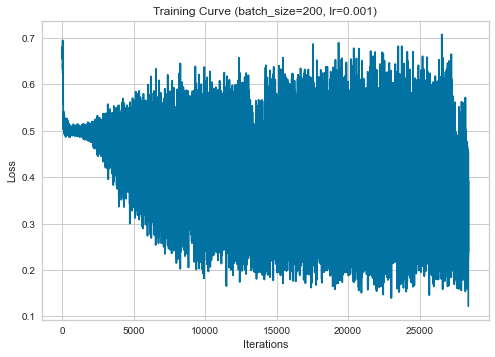

In [151]:
iters, losses = run_training()
torch.save(model.state_dict(), MODEL_PATH)
plot_loss(iters, losses)

In [152]:
model.load_state_dict(torch.load(MODEL_PATH)) #👌 

<All keys matched successfully>

## Make recommendations using the NeuMF model

In [153]:
playlist_for_test = np.random.choice(test_playlist_tracks_df['pid'].tolist())
ground_truth = test_playlist_tracks_df[test_playlist_tracks_df['pid'] == playlist_for_test]

playlist_embedding_weight_matrix = model.pl_mlp_embedding.weight
chosen_playlist_vector = playlist_embedding_weight_matrix[playlist_for_test]

In [154]:
# Hyperparameter Search
# NOTE: WILL TAKE AGES TO RUN
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(50,100))
visualizer.fit(playlist_embedding_weight_matrix.detach().cpu().numpy())
visualizer.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [156]:
print("Fitting a KMeans model with 100 clusters to the embedding weight matrix for playlists")
km_model = KMeans(n_clusters=100, random_state=0, verbose=0).fit(playlist_embedding_weight_matrix.detach().cpu().numpy())

Fitting a KMeans model with 100 clusters to the embedding weight matrix for playlists


In [158]:
chosen_playlist_vector = chosen_playlist_vector.detach().cpu().numpy().reshape(1,-1)
playlist_predictor = km_model.predict(chosen_playlist_vector)
playlist_labels = km_model.labels_

similar_playlists = []
for pid, playlist_label in enumerate(playlist_labels):
    if playlist_label == playlist_predictor:
        similar_playlists.append(pid)
print(f'other playlists in cluster: {len(similar_playlists)}')

other playlists in cluster: 5765


In [160]:
from collections import OrderedDict
tracks = []
for pid in similar_playlists:
    tracks += list(total_playlist_tracks_df[total_playlist_tracks_df['pid'] == pid]['cat_codes'])
print(f'other tracks from similar_playlists in cluster: {len(tracks)}') 

tracks = list(OrderedDict.fromkeys(tracks))

pids_pred = torch.tensor(np.full(len(tracks), playlist_for_test, dtype='int32')).to(device)
tracks_pred = torch.tensor(np.array(tracks, dtype='int32')).to(device)
model.eval()
results = model(pids_pred, tracks_pred)
print("Retrieved predictions from trained model...")

other tracks from similar_playlists in cluster: 6332
Retrieved predictions from trained model...


In [161]:
unique_playlist_tracks_df = total_playlist_tracks_df.drop_duplicates(subset=['cat_codes'])
unique_playlist_tracks_df = unique_playlist_tracks_df.sort_values(by=['cat_codes'], ascending=False)

unique_tids_by_cat_codes = np.array(unique_playlist_tracks_df['tid'])
unique_result_merged = unique_playlist_tracks_df.merge(tracks_features_df, on='tid')
other_features_by_cat_codes = np.array([(row['track_name'],row['artist_name']) for i, row in unique_result_merged.iterrows()])

def get_results_df():
    for i, probability in enumerate(tqdm(results)):
        tid = unique_tids_by_cat_codes[i]
        other_features = other_features_by_cat_codes[i]
        yield probability.item(), tid, *other_features

results_df = pd.DataFrame(get_results_df(), index=range(len(results)), columns=['probability', 'tid','track_name', 'artist_name'])
results_df = results_df.sort_values(by=['probability'], ascending=False)

nmf_preds = results_df.head(NUM_WITHHELD)
nmf_preds

100%|███████████████████████████████████████████████████████████████████████████| 5555/5555 [00:00<00:00, 15076.39it/s]


,probability,tid,track_name,artist_name
4609,0.866009,164810,Meditation,Jamie Lawrence
1681,0.865374,168173,I Saw Him Standing There,Tiffany
4913,0.864866,164452,Up To You - Bonus Track,Echosmith
5270,0.863961,164050,Teenagers,My Chemical Romance
2463,0.863807,167262,Ghosts,Michael Jackson
298,0.862502,169744,Maybe,Teyana Taylor
5012,0.861138,164343,Sinsemilla,Black Uhuru
5250,0.860376,164072,Vogue,Madonna
1771,0.859844,168066,At Seventeen,Janis Ian
2409,0.859379,167325,Hi,R2Bees


In [164]:
def predictions_nmf():
    for idx,row in nmf_preds.iterrows():
        yield (row['tid'], playlist_for_test, idx)

predictions_nmf_df = pd.DataFrame(predictions_nmf(), columns=['tid','pid', 'pos'])
nmf_model_eval = Evaluator(predictions_nmf_df, ground_truth.iloc[25:])
nmf_model_eval.evaluate()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.18it/s]


r_precision    0.0
ndcg           0.0
songs_click    3.5
dtype: float64

In [165]:
test_playlist_tracks_incomplete_df.query('pid == @playlist_for_test')[['tid','pos']].merge(tracks_features_df[['tid','artist_name','track_name']], on='tid')

,tid,pos,artist_name,track_name
0,166634,0,Nicky Jam,El Perdón
1,114869,1,ZHU,Faded - Original Mix
2,154368,2,Shaggy,I Need Your Love
3,132706,3,Calvin Harris,Open Wide
4,154828,4,Nicki Minaj,The Night Is Still Young
5,21707,5,Eros Ramazzotti,Cosas De La Vida (Cose Della Vita)
6,89059,6,Adam Lambert,Ghost Town
7,133417,7,Jack Ü,Where Are Ü Now (with Justin Bieber)
8,74831,8,Marc Anthony,Vivir Mi Vida
9,143849,9,Taylor Swift,Bad Blood


In [166]:
ground_truth[['tid','pos']].merge(tracks_features_df[['tid','artist_name','track_name']], on='tid')

,tid,pos,artist_name,track_name
0,166634,0,Nicky Jam,El Perdón
1,114869,1,ZHU,Faded - Original Mix
2,154368,2,Shaggy,I Need Your Love
3,132706,3,Calvin Harris,Open Wide
4,154828,4,Nicki Minaj,The Night Is Still Young
...,...,...,...,...
153,126352,171,Drake,Pop Style
154,22536,172,Drake,Too Good
155,83884,173,Drake,Summers Over Interlude
156,91580,174,Drake,Fire & Desire
